<a href="https://colab.research.google.com/github/Melo987/-v2/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install matplotlib==3.0.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l 

In [9]:
class Residual(nn.Module):
  def __init__(self,input_channels,num_channels,use_1x1conv=False,strides=1):
    super().__init__()
    self.conv1=nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1,stride=strides)
    self.conv2=nn.Conv2d(num_channels, num_channels,kernel_size=3, padding=1)

    if use_1x1conv:
      self.conv3=nn.Conv2d(input_channels,num_channels,kernel_size=1,stride=strides)
    else:
      self.conv3=None
    self.bn1=nn.BatchNorm2d(num_channels)
    self.bn2=nn.BatchNorm2d(num_channels)
  
  def forward(self,X):
    Y=F.relu(self.bn1(self.conv1(X)))
    Y=self.bn2(self.conv2(Y))
    if self.conv3:
      X=self.conv3(X)
    Y+=X
    return F.relu(Y)

In [10]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape
#高宽不变

torch.Size([4, 3, 6, 6])

In [11]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape
#高宽减半

torch.Size([4, 6, 3, 3])

In [12]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [17]:
def resnet_block(input_channels,num_channels,num_residuals,first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(input_channels,num_channels,use_1x1conv=True,strides=2))
    else:
      blk.append(Residual(num_channels,num_channels))
  return blk

ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。 第一个模块的通道数同输入通道数一致。 由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。 之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

In [18]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [19]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [20]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [31]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.013, train acc 0.998, test acc 0.921
364.8 examples/sec on cuda:0


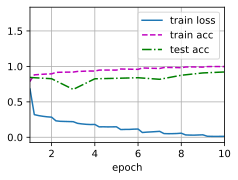

In [32]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

lr=0.05,loss 0.010, train acc 0.998, test acc 0.855,过拟合有点严重

lr=0.1，loss 0.020, train acc 0.994, test acc 0.914，损失和训练精度都有所下降，但测试精度提升，过拟合下降

lr=0.12，loss 0.030, train acc 0.990, test acc 0.891

lr=0.11，loss 0.022, train acc 0.993, test acc 0.912

lr=0.08，loss 0.015, train acc 0.996, test acc 0.889，过拟合

将图片resize为224*224时，lr=0.1，loss 0.013, train acc 0.998, test acc 0.921